In [32]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

print(tf.__version__)

2.2.0


In [33]:
tf.math.sin(tf.constant(3, dtype=tf.float64)).numpy()

0.1411200080598672

In [34]:
Pec = Rey = 100
# model = keras.Sequential(name="2D_PST_NS_INN")
# model.add(keras.Input(shape=(3,)))
# for i in range(10):
#     model.add(layers.Dense(50, activation=tf.math.sin, name=f"hidden_{i}"))
# model.add(layers.Dense(4, activation=tf.math.sin, name="output"))
# model.add(layers.Dense(4, name="temp_NS_residuals"))

init_model = keras.Sequential(name="2D_PST_NN")
init_model.add(keras.Input(shape=(3,), name="time_pos_input"))
for i in range(10):
    init_model.add(layers.Dense(50, activation=tf.math.sin, name=f"hidden_{i}"))

trained_concentration = layers.Dense(1, activation=tf.math.sin, name="PS_concentration")(init_model.output)

trained_velocity      = layers.Dense(3, activation=tf.math.sin, name="v_field")(init_model.output)

#This dummy layer will eventually be replaced by a custom layer with no trainable parameters that evaluate the relevant NS equations with gradient tape
trained_residuals     = layers.Dense(4, activation=tf.math.sin, name="temp_NS_residuals")(layers.concatenate([trained_concentration, trained_velocity], name="all_trained"))

model = keras.Model(
    inputs  = init_model.inputs,
    outputs = [trained_concentration, trained_residuals],
    name    = "2D_PST_NS_INN"
)

model.summary()

Model: "2D_PST_NS_INN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
time_pos_input (InputLayer)     [(None, 3)]          0                                            
__________________________________________________________________________________________________
hidden_0 (Dense)                (None, 50)           200         time_pos_input[0][0]             
__________________________________________________________________________________________________
hidden_1 (Dense)                (None, 50)           2550        hidden_0[0][0]                   
__________________________________________________________________________________________________
hidden_2 (Dense)                (None, 50)           2550        hidden_1[0][0]                   
______________________________________________________________________________________

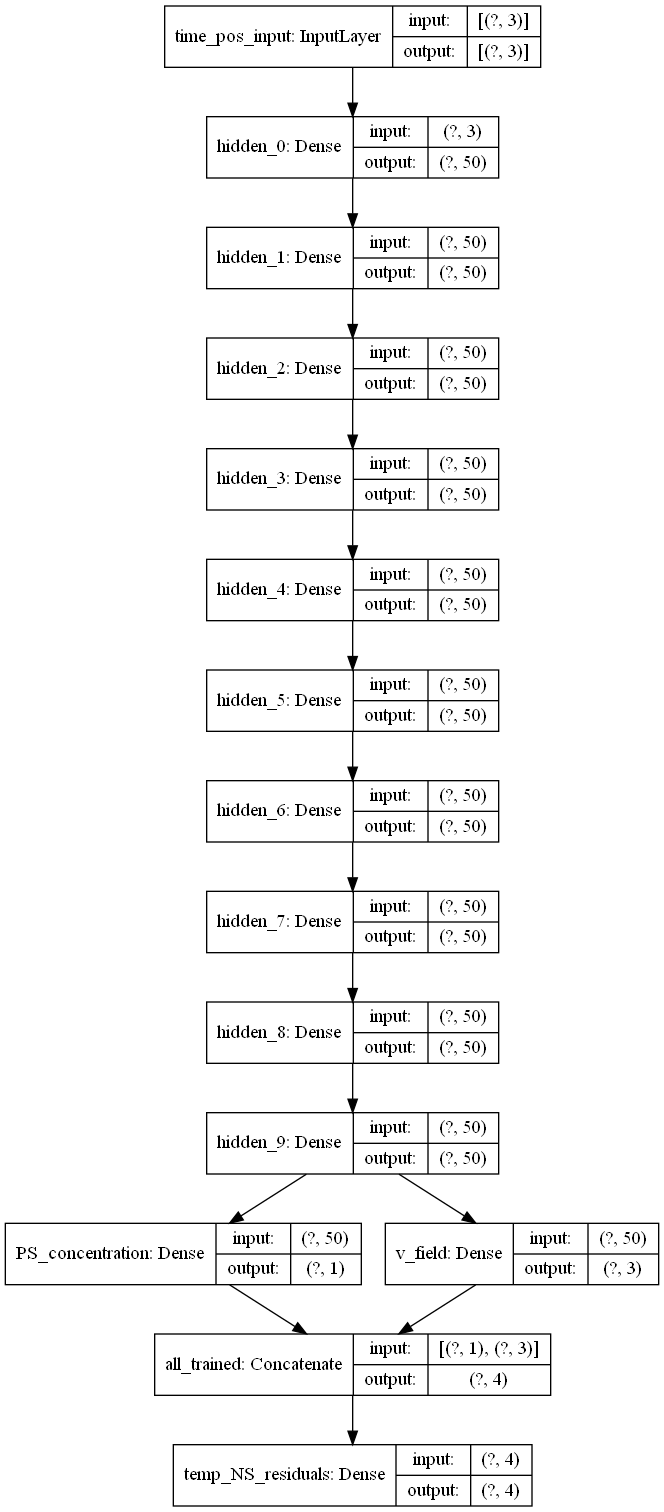

In [35]:
keras.utils.plot_model(model, f"{model.name}.png", show_shapes=True)

In [52]:
n = 10 # number of samples
m = 3  # number of features
x = tf.ones((n,m))

# Eager evaluation of NN
est_c, NS_residual = model(x)
print(est_c)
print(NS_residual)

tf.Tensor(
[[0.07273967]
 [0.07273967]
 [0.07273967]
 [0.07273967]
 [0.07273967]
 [0.07273967]
 [0.07273967]
 [0.07273967]
 [0.07273967]
 [0.07273967]], shape=(10, 1), dtype=float32)
tf.Tensor(
[[ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]
 [ 0.01519815 -0.18332186 -0.33774337  0.5506565 ]], shape=(10, 4), dtype=float32)


In [55]:
# Gradient tape can be run on this to calculate gradients required for lift and drag forces
get_trained_vel_prs = keras.Model(
    inputs  = init_model.inputs,
    outputs = trained_velocity,
    name    = "2D_PST_VPL"
)

# u, v, p = (vel_prs_array := get_trained_vel_prs(x))[:,0], vel_prs_array[:,1], vel_prs_array[:,2]

# Eager evaluation of NN
vel_prs_array = get_trained_vel_prs(x)
u, v, p = vel_prs_array[:,0], vel_prs_array[:,1], vel_prs_array[:,2]
print(u)
print(v)
print(p)

tf.Tensor(
[-0.20399009 -0.20399009 -0.20399009 -0.20399009 -0.20399009 -0.20399009
 -0.20399009 -0.20399009 -0.20399009 -0.20399009], shape=(10,), dtype=float32)
tf.Tensor(
[0.4215369 0.4215369 0.4215369 0.4215369 0.4215369 0.4215369 0.4215369
 0.4215369 0.4215369 0.4215369], shape=(10,), dtype=float32)
tf.Tensor(
[-0.19560263 -0.19560263 -0.19560263 -0.19560263 -0.19560263 -0.19560263
 -0.19560263 -0.19560263 -0.19560263 -0.19560263], shape=(10,), dtype=float32)


In [ ]:
# model.save(f"C:/UserTemp/models/{model.name}_model_{datetime.now().strftime('%y.%m.%d.%H.%M.%S')}")
# model.save_weights(f"C:/UserTemp/model_weights/{model.name}_model_{datetime.now().strftime('%y.%m.%d.%H.%M.%S')}")